In [1]:
import numpy as np
import itertools
import multiprocessing
import pickle
%matplotlib inline
from matplotlib import pyplot as plt

List of parameters

In [2]:
def detailed_sparse_setting():
    # SMALL setting experiments
    setting_name = 'detailed_sparse'
    common = {'v_n': 2, 'v_k': 2, 'v_seed': 43, 'do_transform': True, 'time_limit': 20,
              'num_iterations': 2000, 'log_interval': 25, 'num_eval_episodes': 10, 'eval_interval': 10,
             'alpha': 1.0, 'sparsity': 0.5, 'l2_decoder_coeff': 1e-3, 'collect_episodes_per_iteration': 5,
             'l1coeff': 1e-4, 'learning_rate': 1e-3}
    params = {
        'model_train_epochs': [4, 5],
        'curiosity_interval': [4, 5]
    }
    return setting_name, common, params

Showing the number of total runs

In [3]:
setting_name, common, params = detailed_sparse_setting()

In [4]:
np.prod([len(y) for x, y in params.items()])

4

Creating a list of all runs from a dictionary of parameters

In [5]:
all_params = list(itertools.product(*[[(x, z) for z in y] for x, y in params.items()]))

In [6]:
len(all_params)

4

In [7]:
all_params = [dict(t) for t in all_params]

In [8]:
all_params

[{'model_train_epochs': 4, 'curiosity_interval': 4},
 {'model_train_epochs': 4, 'curiosity_interval': 5},
 {'model_train_epochs': 5, 'curiosity_interval': 4},
 {'model_train_epochs': 5, 'curiosity_interval': 5}]

In [9]:
pickle.dump(all_params, open("setting_%s.txt" % setting_name, "wb"))

Running the setting

In [10]:
!rm -rf output/{setting_name}*

In [11]:
def process_i(i):
    param = all_params[i]
    print(i, param)
    to_run = {x: y for x, y in param.items()}
    to_run["name"] = "output/%s%010d" % (setting_name, i)
    to_run.update(common)
    from exp_poc import experiment
    experiment(**to_run)

In [12]:
pool = multiprocessing.Pool(10)
pool.map(process_i, range(len(all_params)))

1 {'model_train_epochs': 4, 'curiosity_interval': 5}
0 {'model_train_epochs': 4, 'curiosity_interval': 4}
2 {'model_train_epochs': 5, 'curiosity_interval': 4}
3 {'model_train_epochs': 5, 'curiosity_interval': 5}
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
1000/1000 [==============================] - 0s 71us/sample - loss: 0.0041


[None, None, None, None]

Process ForkPoolWorker-7:
Process ForkPoolWorker-10:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


Loading the data...

In [14]:
run_id = 3
run_params = all_params[run_id]
prefix = "output/%s%010d" % (setting_name, run_id)
history = pickle.load(open(prefix + ".history.pkl", "rb"))
weights = pickle.load(open(prefix + ".weights.pkl", "rb"))
curiosity_loss, eval_returns, train_returns, eval_loss = history

In [15]:
print("Final eval loss: %.2f" % eval_loss)

Final eval loss: 0.00


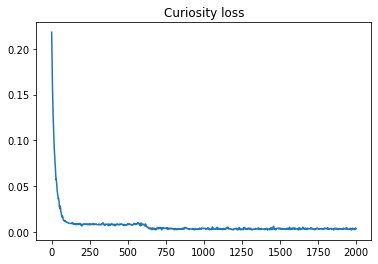

In [16]:
plt.figure()
plt.title("Curiosity loss")
plt.plot(curiosity_loss)
plt.show()

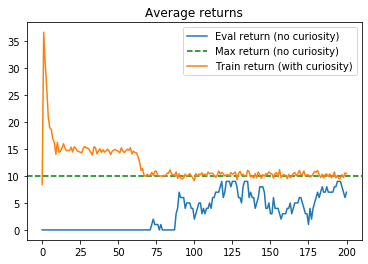

In [17]:
plt.figure()
plt.title("Average returns")
plt.plot(eval_returns, label="Eval return (no curiosity)")
plt.axhline(10, ls="--", color="green", label="Max return (no curiosity)")
plt.plot(train_returns, label="Train return (with curiosity)")
plt.legend()
plt.show()

We have $o_t=Qs_t$, where $Q$ comes from the environment encoder, $f_t=Fo_t$, where $F$ comes from the weights of the decoder and $f_{t+1}\approx A[f_{t},a_{t}]+b$ where $A$ and $b$ are given in weights of the environment model.

The true dynamics is $s_{t+1}=B[s_t,a_t]$ where

$$
B=[[1,0,1,0];[0,1,0,1]], B\colon 2\times 4
$$

Since we regularize $A\colon 2\times 4$ to be sparse, we expect it to converge to something similar to $B$...

To analyze how good $A$ is, we create the following metric. We know that two features must be such that they are preserved over the iterations, with the exception that actions change them. Therefore, the left 2x2 submatrix must be an identity matrix. Then, there are two cases: either $f_1\sim s_1$ or $f_1\sim s_2$. We measure the distance from that matrix to the identity matrix

In [18]:
def quality(weights):
    """Compute how well the weights correspond to the simple dynamics that we know.
    
    Always non-positive. Best value: 0
    """
    F, (A, b) = weights
    F = F.T # Keras transposes everything
    A = A.T
    A_sub2x2 = A[:,:2]
    quality_loss = np.linalg.norm((A_sub2x2 - np.eye(2)).flatten(), ord=1)
    return -quality_loss
print(quality(weights[-1]))

-3.6524848341941833


In [19]:
quality_repr = [quality(t) for t in weights]

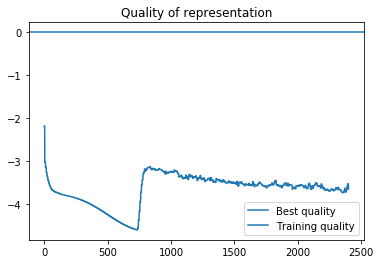

In [20]:
plt.title("Quality of representation")
plt.axhline(0, label="Best quality")
plt.plot(quality_repr, label="Training quality")
plt.legend()
plt.show()

# Combining everything together

In [21]:
# https://github.com/sergeivolodin/OptMLProject/blob/master/create_analyze_runs_helpers.py

def shorten_name(n):
    """ Shorten aba_caba to a_c """
    return '_'.join([x[:3] if len(x) else '' for x in n.split('_')])

def shorten_dict(d, filename = False):
    """ Shorten dictionary into a string """
    if filename:
        return '_'.join([shorten_name(x) + '-' + str(y) for x, y in d.items()])
    if len(d) == 1:
        return list(d.values())[0]
    return ', '.join([shorten_name(x) + ': ' + str(y) for x, y in d.items()])

In [22]:
run_id = 12
def process_plot_run(run_id):
    run_params = all_params[run_id]
    prefix = "output/%s%010d" % (setting_name, run_id)
    history = pickle.load(open(prefix + ".history.pkl", "rb"))
    weights = pickle.load(open(prefix + ".weights.pkl", "rb"))
    curiosity_loss, eval_returns, train_returns, eval_loss = history

    fig = plt.figure(figsize=(16, 4))
    fig.patch.set_facecolor('lightgreen')
    fig.suptitle('Param id %d: %s' % (run_id, str(shorten_dict(run_params))), fontsize=16)
    plt.subplot(1, 3, 1)

    plt.title("Curiosity loss")
    plt.plot(curiosity_loss, label="Train loss")
    plt.axhline(eval_loss, ls="--", color="blue", label="Final eval loss")
    plt.axhline(0, ls="--", color="green", label="Best")
    plt.legend()
    #plt.show()

    #plt.figure()
    plt.subplot(1, 3, 2)

    plt.title("Average returns")
    plt.plot(eval_returns, label="Eval return (no curiosity)")
    plt.axhline(10, ls="--", color="green", label="Max return (no curiosity)")
    plt.plot(train_returns, label="Train return (with curiosity)")
    plt.legend()
    #plt.show()

    quality_repr = [quality(t) for t in weights]

    plt.subplot(1, 3, 3)
    plt.title("Quality of representation")
    plt.axhline(0, ls="--", color="green", label="Best quality")
    plt.plot(quality_repr, label="Training quality")
    plt.legend()
    plt.show()
process_plot_run(run_id)

IndexError: list index out of range

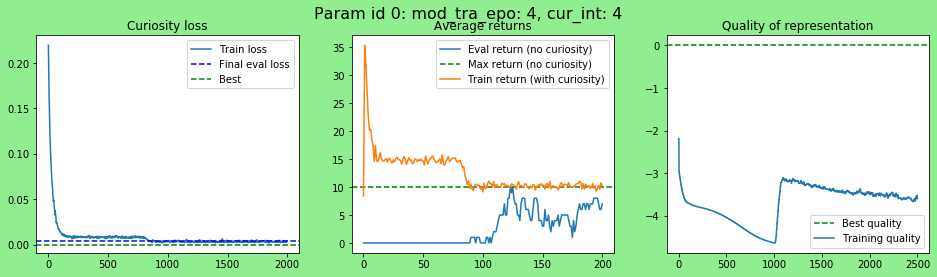

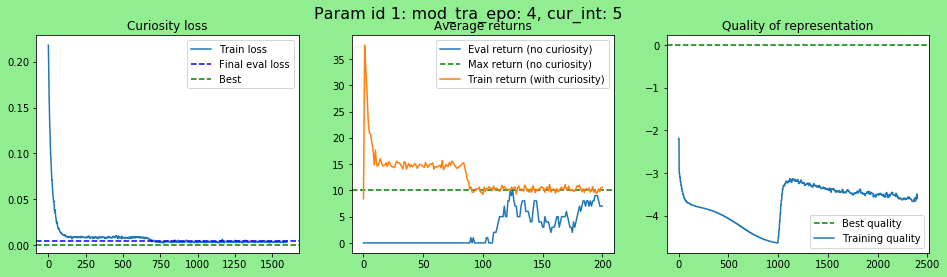

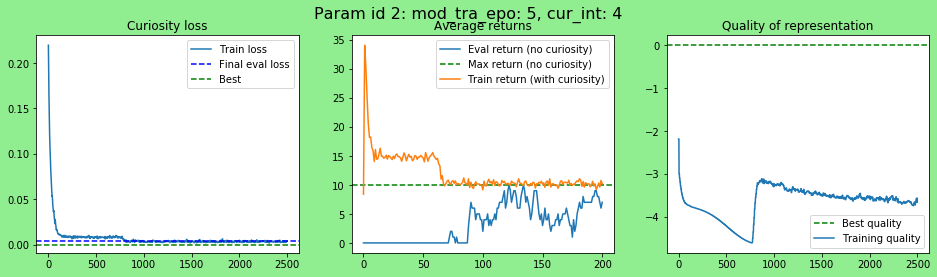

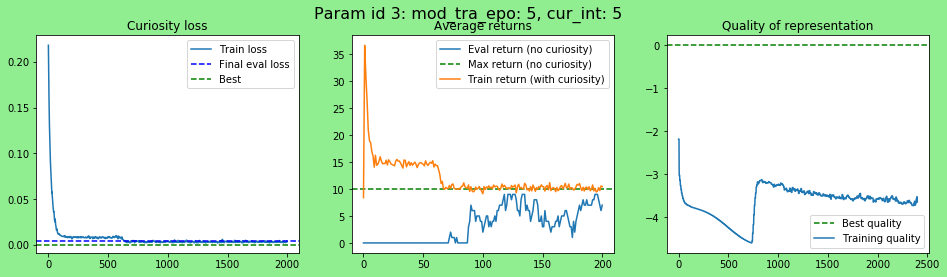

In [23]:
for i in range(len(all_params)):
    process_plot_run(i)

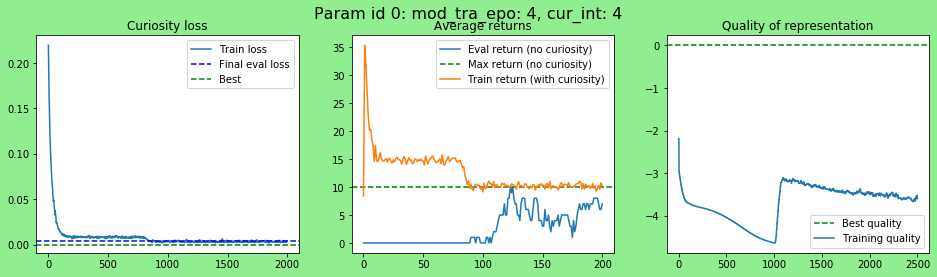

In [24]:
selected_idx = 0
prefix = "output/%s%010d" % (setting_name, selected_idx)
weights = pickle.load(open(prefix + ".weights.pkl", "rb"))
process_plot_run(selected_idx)

In [26]:
F, (A, b) = weights[selected_idx]
F = F.T # Keras transposes everything
A = A.T
A_sub2x2 = A[:,:2]
A_sub2x2

array([[0.25339055, 0.03676939],
       [0.9880707 , 0.5841136 ]], dtype=float32)

Doesn't work even with increased sparsity and more iterations. The agent converges with more iterations though.

Trying even more iterations...

In [33]:
i = 0
setting_name = "temp"
param = all_params[i]
print(i, param)
to_run = {x: y for x, y in param.items()}
to_run["name"] = "output/%s%010d" % (setting_name, i)
to_run.update(common)
to_run['num_iterations'] = 10000

0 {'model_train_epochs': 4, 'curiosity_interval': 4}


In [34]:
to_run

{'model_train_epochs': 4,
 'curiosity_interval': 4,
 'name': 'output/temp0000000000',
 'v_n': 2,
 'v_k': 2,
 'v_seed': 43,
 'do_transform': True,
 'time_limit': 20,
 'num_iterations': 10000,
 'log_interval': 25,
 'num_eval_episodes': 10,
 'eval_interval': 10,
 'alpha': 1.0,
 'sparsity': 0.5,
 'l2_decoder_coeff': 0.001,
 'collect_episodes_per_iteration': 5,
 'l1coeff': 0.0001,
 'learning_rate': 0.001}

In [35]:
from exp_poc import experiment
tf.random.set_seed()
experiment(**to_run)

Instructions for updating:
Please use `layer.add_weight` method instead.
